In [57]:
import xarray as xr
from dask.distributed import LocalCluster, Client
import dask
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate

import itertools



In [2]:
datapath = '/lus/scratch/shao/data/NEP36_extremes/'
cluster_files = [ f'output_data/cluster_{i}.nc' for i in range(12) ]
clusters_ds = [ xr.open_dataset(file, chunks={'time':439}, engine='h5netcdf') for file in cluster_files ]

In [3]:
plot_clusters = [1, 10]
cluster_names = {1:'Canyons', 10:'Shallows'}

In [72]:
for cluster_ds in clusters_ds:
    cluster_ds['ALK_norm'] = 32.5*cluster_ds['ALK']/cluster_ds['S']
    cluster_ds['DIC_norm'] = 32.5*cluster_ds['DIC']/cluster_ds['S']

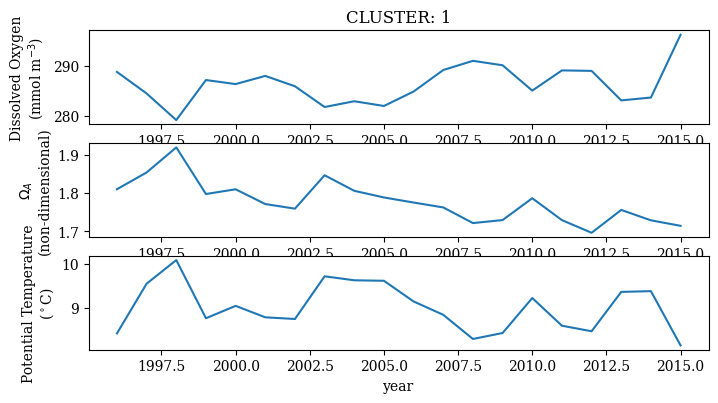

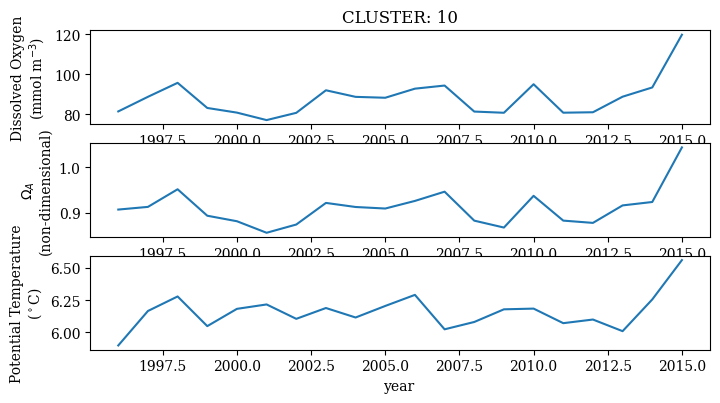

In [79]:
# Plot timeseries of all the relevant variables



timeseries_vars = [
    'O2',
    'OmegaA',
    'T',
    # 'ALK_norm',
    # 'DIC_norm',
    # 'ALK',
    # 'DIC',
]

long_names = dict(
    O2="Dissolved Oxygen",
    OmegaA="$\Omega_A$",
    T="Potential Temperature",
    # ALK_norm="Normalized Alkalinity",
    # DIC_norm="Normalized DIC",
    # ALK="Alkalinity",
    # DIC="DIC",
)

units = dict(
    O2="mmol m$^{-3}$",
    OmegaA="non-dimensional",
    T="$^\circ$C",
    # ALK_norm="mmolk m$^{-3}$",
    # DIC_norm="mmolk m$^{-3}$",
    # ALK="mmolk m$^{-3}$",
    # DIC="mmolk m$^{-3}$"
)



for cluster_label, cluster_ds in enumerate(clusters_ds):
    if cluster_label in plot_clusters:
        plt.figure(figsize=(8,10))    
        for idx, var in enumerate(timeseries_vars):        
            plt.subplot(7,1,idx+1)
            cluster_ds[var].groupby('time.year').mean('time').mean('stacked_y_x').plot()
            plt.ylabel(f"{long_names[var]}\n({units[var]})")
            if idx == 0:
                plt.title(f'CLUSTER: {cluster_label}')
    

IndexError: index 3 is out of bounds for axis 0 with size 3

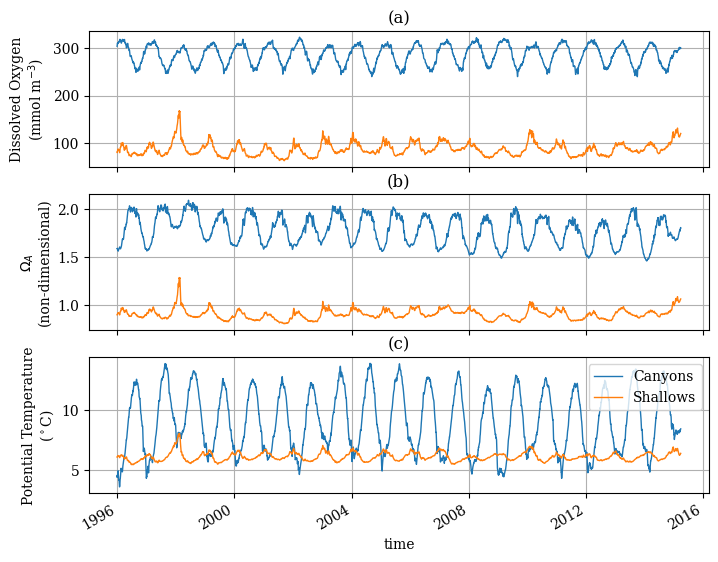

In [68]:
fig, axs = plt.subplots(3, 1, sharex=True,figsize=(8,6))

subpanel = ['a','b','c']
plt.rcParams["font.family"] = "Serif"


for i, var in enumerate(timeseries_vars):
    ax = axs[i]
    cluster_id = plot_clusters[0]
    clusters_ds[cluster_id][var].mean('stacked_y_x').plot(label=cluster_names[cluster_id], ax=ax, linewidth=1)
    cluster_id = plot_clusters[1]
    clusters_ds[cluster_id][var].mean('stacked_y_x').plot(label=cluster_names[cluster_id], ax=ax, linewidth=1)
    ax.set_ylabel(f"{long_names[var]}\n({units[var]})")
    if i != 2:
        ax.set_xlabel('')
    if i == 2:
        ax.legend()
    ax.grid()
    ax.set_title(f'({subpanel[i]})')
fig.tight_layout()

In [6]:
# Split by upwelling season
downwelling_months = [10, 11, 12, 1, 2, 3]
upwelling_months   = [4, 5, 6, 7, 8, 9]
timeseries_vars = ['O2','OmegaA','T']
hist_kwargs = {
    'alpha':0.5,
    'density':True,
    'bins':500
}

def filter_by_season_and_values(ds,month_range):       
    ds_out = ds.where(ds['time.month'].isin(month_range),drop=True)
    return ds_out

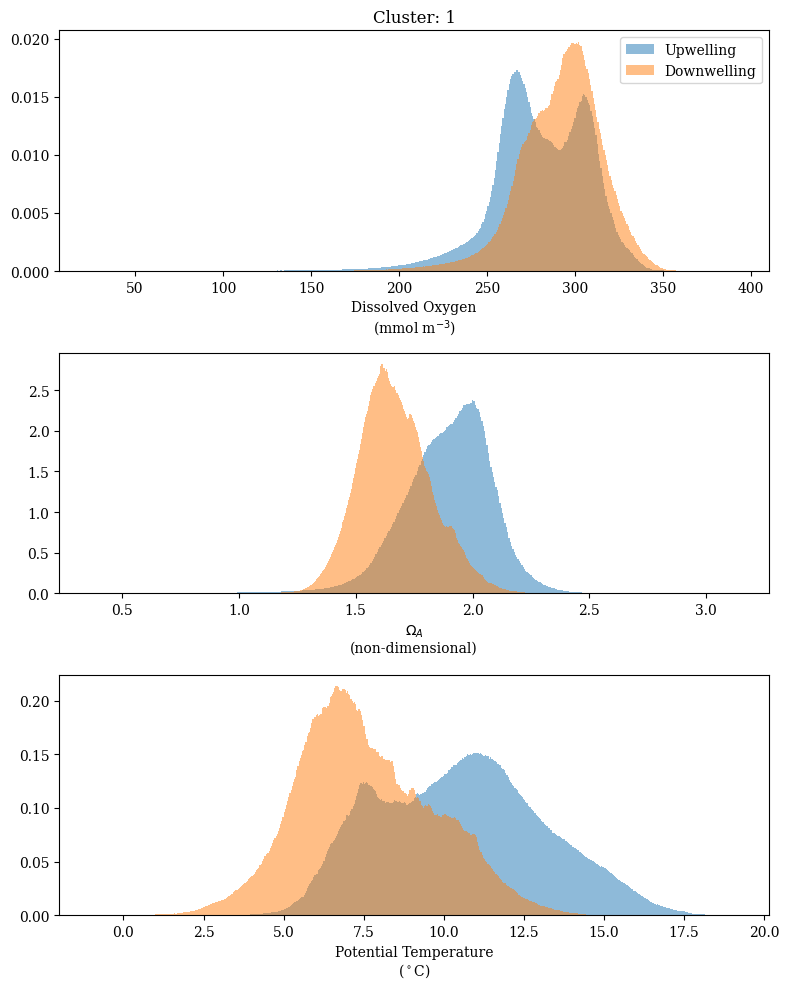

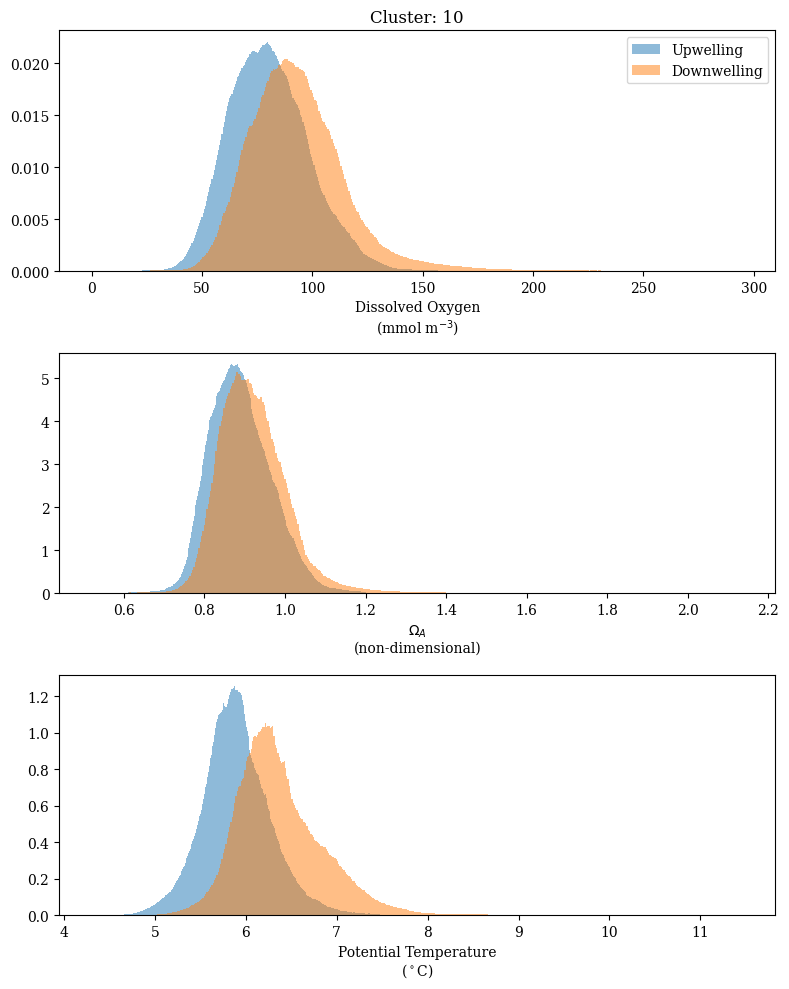

In [7]:
downwelling = {}
upwelling = {}

for cluster_label, cluster_ds in enumerate(clusters_ds):
    if cluster_label in plot_clusters:
        plt.figure(figsize=(8,10))
        ds_months = cluster_ds.groupby('time.month')    
        # For every dataset separate data in upwelling and downwelling months
        upwelling_ds = filter_by_season_and_values(cluster_ds, upwelling_months)
        downwelling_ds = filter_by_season_and_values(cluster_ds, downwelling_months)
        downwelling[cluster_label] = downwelling_ds.copy()
        upwelling[cluster_label] = upwelling_ds.copy()
        for idx, var in enumerate(timeseries_vars):         
            plt.subplot(3,1,idx+1)
            plt.hist(upwelling_ds[var].to_numpy().flatten(),label='Upwelling', **hist_kwargs)
            plt.hist(downwelling_ds[var].to_numpy().flatten(),label='Downwelling', **hist_kwargs)
            plt.xlabel(long_names[var])
            if idx == 0:
                plt.title(f'Cluster: {cluster_label}')
                plt.legend()
        plt.tight_layout()

In [8]:
linecolors = dict(
    pdf = 'k',
    cdf = 'b'
)
linestyles = dict(
    Upwelling = '-',
    Downwelling = '--'
)

def plot_cdf_pdf(da_upwelling, da_downwelling, nbins=100):
    da_list = ((da_upwelling, 'Upwelling'), (da_downwelling, 'Downwelling'))
    for da, label in da_list:
        data = da.to_numpy().flatten()
        hist, edges = np.histogram(data, bins=nbins, density=True)
        cdf = integrate.cumtrapz(hist,edges[1:])
        
        plt.plot(edges[1:], hist, color=linecolors['pdf'], linewidth=1, linestyle = linestyles[label], label=f'{label}-PDF')
        plt.plot(edges[2:], cdf, color=linecolors['cdf'], linewidth=1, linestyle = linestyles[label], label=f'{label}-CDF')

(4.0, 9.0)

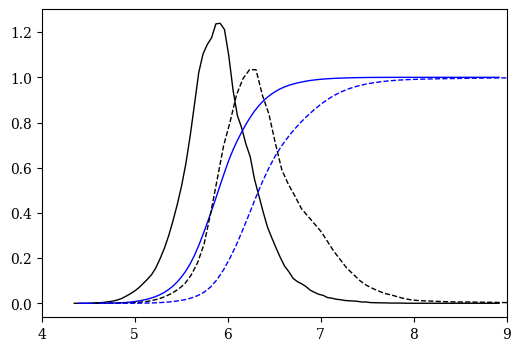

In [9]:
plt.figure(figsize=(6,4))
plot_cdf_pdf(upwelling[10].T, downwelling[10].T)
plt.xlim([4,9])

In [10]:
linecolors = dict(
    pdf = 'k',
    cdf = 'b'
)
linestyles = dict(
    Upwelling = '-',
    Downwelling = '--'
)

def plot_cdf_pdf(da_upwelling, da_downwelling, nbins=100):
    da_list = ((da_upwelling, 'Upwelling'), (da_downwelling, 'Downwelling'))
    for da, label in da_list:
        data = da.to_numpy().flatten()
        hist, edges = np.histogram(data, bins=nbins, density=True)
        cdf = integrate.cumtrapz(hist,edges[1:])
        
        plt.plot(edges[2:], cdf, color=linecolors['cdf'], linewidth=1, linestyle = linestyles[label], label=f'{label}-CDF')

Cluster label: 1
	O2 Upwelling: 250.1
	O2 Downwelling: 263.9
	OmegaA Upwelling: 1.7
	OmegaA Downwelling: 1.5
	T Upwelling: 14.1
	T Downwelling: 10.6
Cluster label: 10
	O2 Upwelling: 58.3
	O2 Downwelling: 68.0
	OmegaA Upwelling: 0.8
	OmegaA Downwelling: 0.8
	T Upwelling: 6.4
	T Downwelling: 7.0


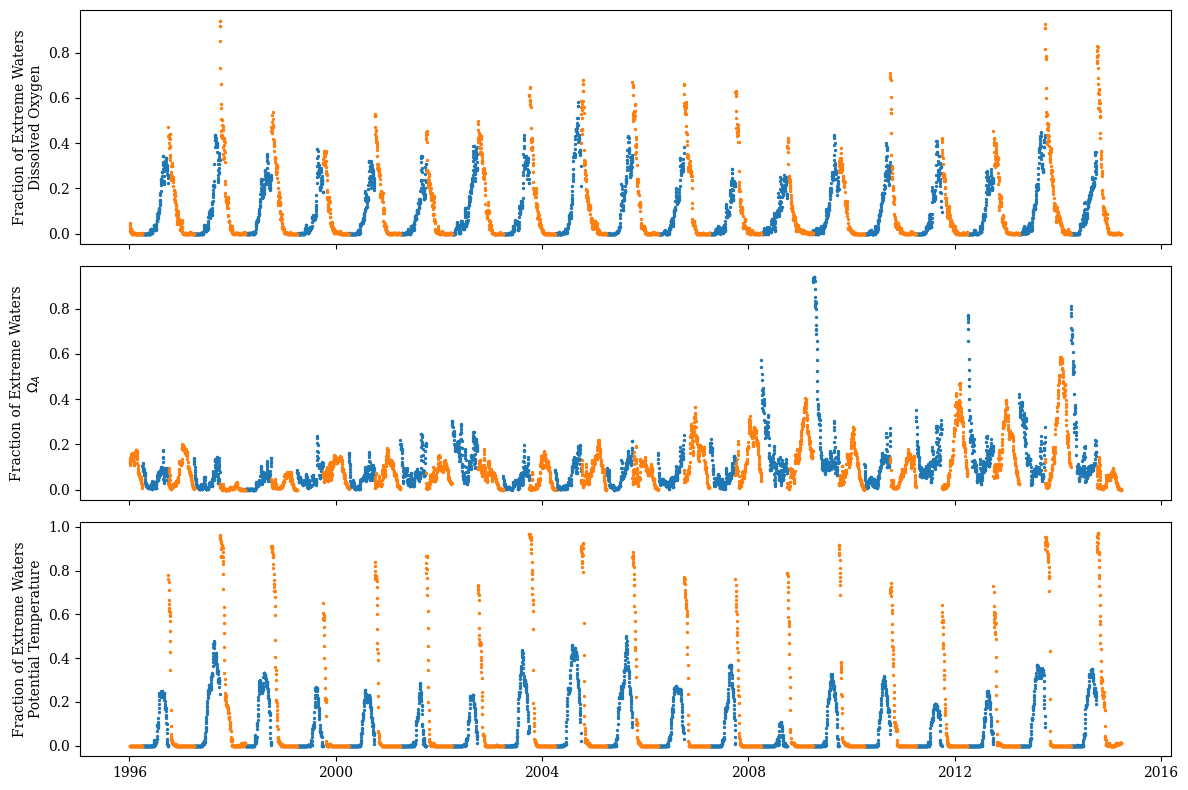

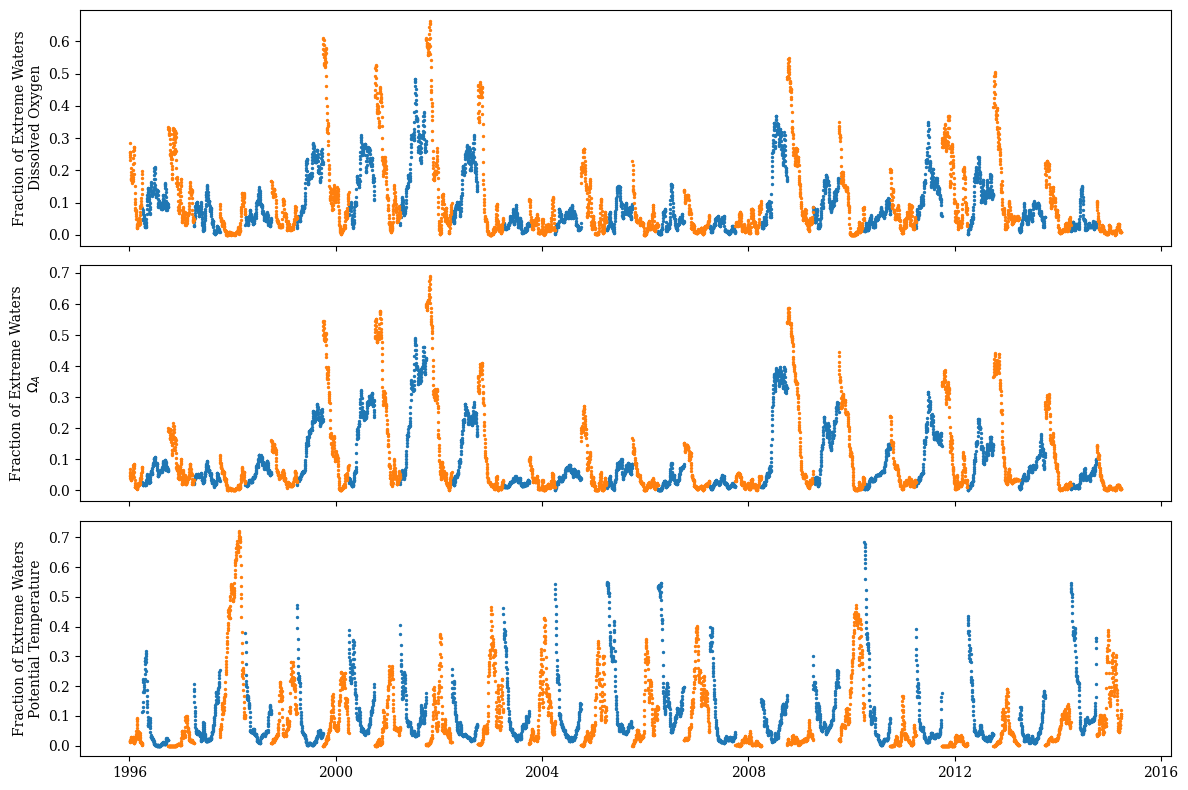

In [94]:
# Calculate extreme thresholds by upwelling/downwelling season and plot timeseries of percentage extremes
downwelling_months = [10, 11, 12, 1, 2, 3]
upwelling_months   = [4, 5, 6, 7, 8, 9]
timeseries_vars = ['O2','OmegaA','T']
hist_kwargs = {
    'alpha':0.5,
    'density':True,
    'bins':100
}

base_percentile = 0.1
percentiles = {
    'O2':base_percentile,
    'OmegaA':base_percentile,
    'T':1-base_percentile
}

def calculate_threshold(ds, percentile, nbins=1000):
    data = ds.to_numpy().flatten()
    hist, edges = np.histogram(data, bins=nbins, density=True)
    cdf = integrate.cumtrapz(hist,edges[1:])
    return np.interp(percentile, cdf, edges[2:])    

def calc_extremes(ds, thresholds, vars):
    """Calculate which points in the domain exceed multiple thresholds"""
    is_extreme = xr.full_like(ds[vars[0]], True, dtype=bool)
    for var in vars:
        if var == 'T':
            is_extreme=is_extreme & (ds[var] >= thresholds[var])
        else:
            is_extreme=is_extreme & (ds[var] <= thresholds[var])
    npts = len(ds.stacked_y_x)
    frac_extreme = is_extreme.sum('stacked_y_x')/npts
    return frac_extreme

def plot_fraction_extreme(ax, ds, thresholds, vars, plot_months, extreme_is_low, label):
    frac_extreme = calc_extremes(ds, thresholds, vars)
    frac_extreme = frac_extreme.where(frac_extreme['time.month'].isin(plot_months))

    ax.scatter(frac_extreme.time, frac_extreme, label=label, s=2)

upwelling = {}
downwelling = {}

thresholds = {}

for cluster_label, cluster_ds in enumerate(clusters_ds):    
    if cluster_label in plot_clusters:
        thresholds[cluster_label] = {}
        thresholds[cluster_label]['upwelling'] = {}
        thresholds[cluster_label]['downwelling'] = {}
        ds_months = cluster_ds.groupby('time.month')
        
        # For every dataset separate data in upwelling and downwelling months
        upwelling_ds = filter_by_season_and_values(cluster_ds, upwelling_months)    
        downwelling_ds = filter_by_season_and_values(cluster_ds, downwelling_months)    
    
        upwelling[cluster_label] = upwelling_ds.copy()
        downwelling[cluster_label] = downwelling.copy()
        print(f'Cluster label: {cluster_label}')
                   
        fig, axs = plt.subplots(3, 1, sharex=True, figsize=(12,8))
        for idx, var in enumerate(timeseries_vars):         
            percentile = percentiles[var]
            upwelling_threshold = calculate_threshold(upwelling_ds[var],percentile)
            downwelling_threshold = calculate_threshold(downwelling_ds[var],percentile)
            thresholds[cluster_label]['upwelling'][var] = upwelling_threshold
            thresholds[cluster_label]['downwelling'][var] = downwelling_threshold
            print(f'\t{var} Upwelling: {upwelling_threshold:.1f}')
            print(f'\t{var} Downwelling: {downwelling_threshold:.1f}')
            plot_fraction_extreme(
                axs[idx],
                upwelling_ds, 
                thresholds[cluster_label]['upwelling'],
                [var],
                upwelling_months,
                percentile == base_percentile,
                'Upwelling'
            )
            plot_fraction_extreme(
                axs[idx],
                downwelling_ds, 
                thresholds[cluster_label]['downwelling'],
                [var],
                downwelling_months,
                percentile == base_percentile,
                'Downwelling'
            )
            axs[idx].set_ylabel(f'Fraction of Extreme Waters\n{long_names[var]}')
        fig.tight_layout()


In [85]:
def calc_concurrent_extremes(ds, thresholds, vars):
    is_extreme = xr.full_like(ds[vars[0]], True, dtype=bool)
    for var in vars:
        if var == 'T':
            is_extreme=is_extreme & (ds[var] >= thresholds[var])
        else:
            is_extreme=is_extreme & (ds[var] <= thresholds[var])
        npts = len(ds.stacked_y_x)
        frac_extreme = is_extreme.sum('stacked_y_x')/npts
        return frac_extreme
    
    

Cluster label: 1
Cluster label: 10


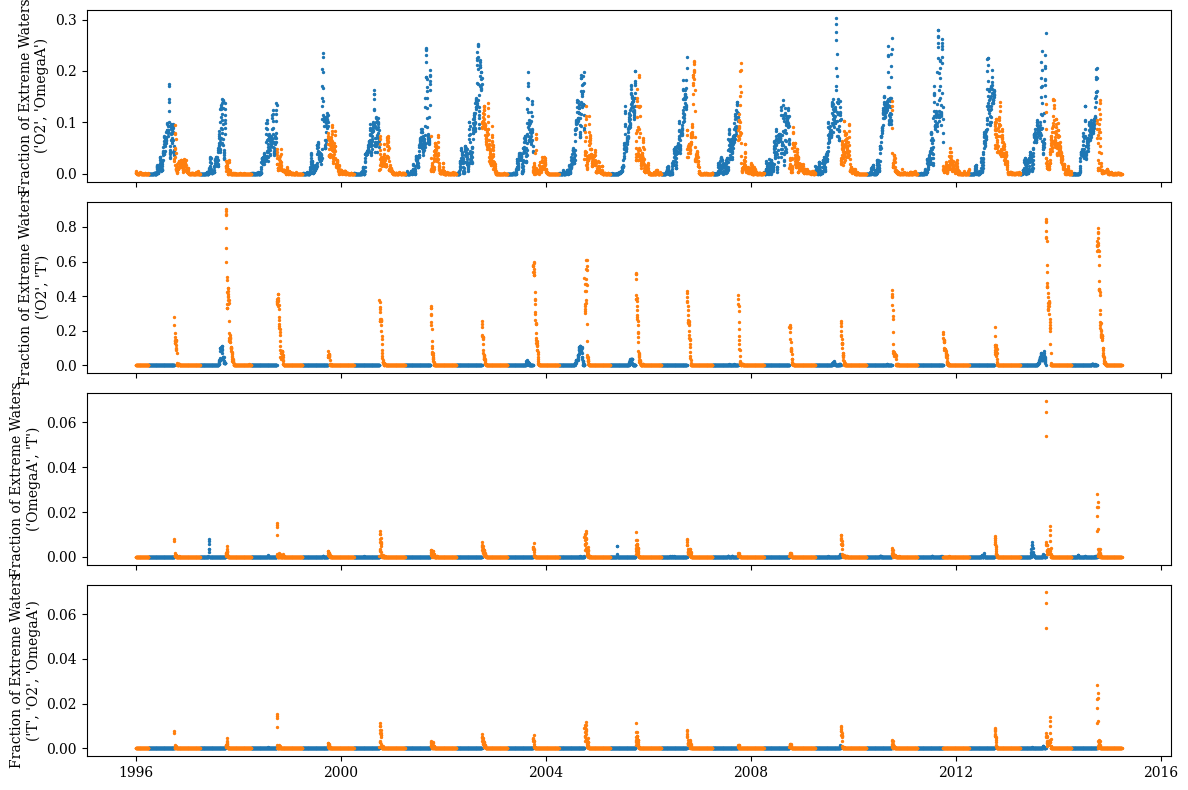

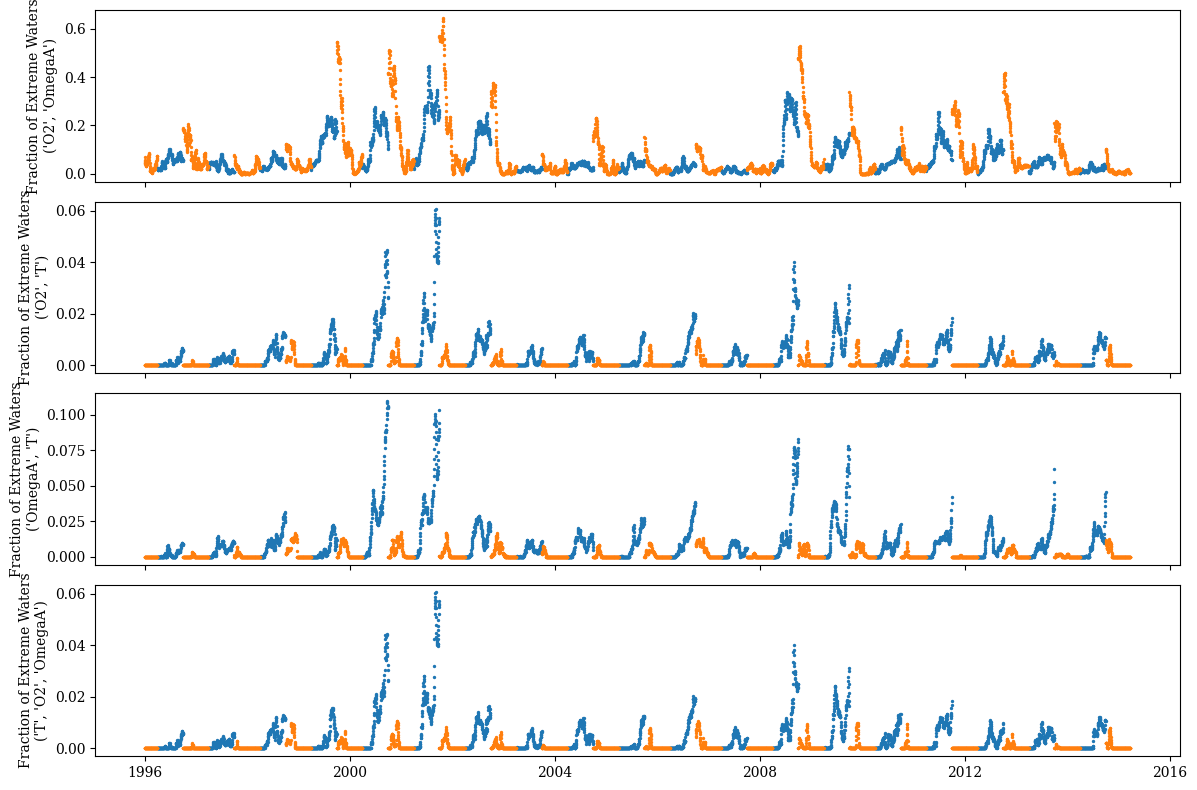

In [95]:
dual_extreme = list(itertools.combinations(timeseries_vars, 2))
dual_extreme += [('T','O2','OmegaA')]

for cluster_label, cluster_ds in enumerate(clusters_ds):    
    if cluster_label in plot_clusters:
        ds_months = cluster_ds.groupby('time.month')
        
        # For every dataset separate data in upwelling and downwelling months
        upwelling_ds = filter_by_season_and_values(cluster_ds, upwelling_months)    
        downwelling_ds = filter_by_season_and_values(cluster_ds, downwelling_months)    
    
        upwelling[cluster_label] = upwelling_ds.copy()
        downwelling[cluster_label] = downwelling.copy()
        print(f'Cluster label: {cluster_label}')

        
        fig, axs = plt.subplots(len(dual_extreme), 1, sharex=True, figsize=(12,8))
        for idx, vars in enumerate(dual_extreme):         
            plot_fraction_extreme(
                axs[idx],
                upwelling_ds, 
                thresholds[cluster_label]['upwelling'],
                vars,
                upwelling_months,
                True,
                'Upwelling'
            )
            plot_fraction_extreme(
                axs[idx],
                downwelling_ds, 
                thresholds[cluster_label]['downwelling'],
                vars,
                downwelling_months,
                True,
                'Downwelling'
            )
            axs[idx].set_ylabel(f'Fraction of Extreme Waters\n{vars}')
        fig.tight_layout()

In [90]:
thresholds[1]

{'upwelling': {'O2': 250.08595135766714,
  'OmegaA': 1.6607223141375487,
  'T': 14.07192254021393},
 'downwelling': {'O2': 263.8613011625254,
  'OmegaA': 1.4835685752963372,
  'T': 10.60677252544098}}

[('O2', 'OmegaA'), ('O2', 'T'), ('OmegaA', 'T')]